# Advanced Units - Advanced Deep Learning

In [1]:
from PIL import Image
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import urllib.request
import zipfile
torch.cuda.is_available()

True

In [2]:
folder_path = 'uav_image_packet_loss_distortion'

if os.path.exists(folder_path):
    local_data = True   
local_data

True

In [3]:
if(not local_data):
    print(local_data)
    gauth = GoogleAuth()
    #gauth.LocalWebserverAuth()  # This will open a new tab in your web browser for authentication
    drive = GoogleDrive(gauth)

    # Get the list of all files and folders in the root of Google Drive
    file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()

    # Filter the list to include only folders
    folder_list = [file for file in file_list if file['mimeType'] == 'application/vnd.google-apps.folder']

    # Print the names and IDs of the folders
    for folder in folder_list:
        print(f"Folder Name: {folder['title']}")
        print(f"Folder ID: {folder['id']}")


In [4]:
if ( not local_data):# Specify the folder ID of the Google Drive folder containing the images
    folder_id = folder['id']

    # Retrieve all files in the folder
    file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()

    # Create an empty DataFrame to store the image metadata
    df = pd.DataFrame(columns=['Image', 'Title'])

    # Iterate over the files and store the image metadata
    data = []
    for file in file_list:
        # Check if the file is an image
        if file['mimeType'].startswith('image/'):
            # Add the image metadata to the DataFrame
            data.append({'Image': file['webContentLink'], 'Title': file['title']})

    # Concatenate the data into the DataFrame
    df = pd.concat([df, pd.DataFrame(data)], ignore_index=True)

    # Display the DataFrame
    print(df)


In [5]:
if ( not local_data):

    file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()

    # Find the folder by name
    folder = next((f for f in file_list if f['title'] == folder['title'] and f['mimeType'] == 'application/vnd.google-apps.folder'), None)

    # Check if folder found
    if folder is None:
        print(f"Folder '{folder['title']}' not found.")
    else:
        # Get the list of files in the folder
        file_list = drive.ListFile({'q': f"'{folder['id']}' in parents and trashed=false"}).GetList()

        # Filter JPG files in the folder
        jpg_files = [f for f in file_list if f['mimeType'] == 'image/jpeg']



In [6]:
resized_images = []

if( not local_data):

    target_size = (128, 128)

    # Loop through each JPG file

    start_time = time.time()
    for jpg_file in jpg_files:
        # Retrieve the JPG file content as an IOBuffer
        jpg_file_buffer = jpg_file.GetContentIOBuffer()

        # Open the image using PIL
        image = Image.open(jpg_file_buffer).convert('RGB')  
        normalized_image = image.point(lambda x: round(x / 255.0 * 255))
        resized_image = normalized_image.resize(target_size)
        image_array = np.array(resized_image)
        if image_array.shape == (128, 128, 3):
            resized_images.append(image_array)

    end_time = time.time()
    processing_time = end_time - start_time

    print(f"Processing time: {processing_time} seconds")
    resized_images[0].shape

In [7]:
# import matplotlib.pyplot as plt

# # Display a few sample images
# sample_images = resized_images[:5]  # Select a few sample images
# for image in sample_images:
#     plt.imshow(image)
#     plt.axis('off')
#     plt.show()

In [8]:
resized_images =[]
target_size = (128, 128)

if(local_data):
    start_time = time.time()
    folder_path = "uav_image_packet_loss_distortion"

    image_list = []
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        image = Image.open(image_path).convert("RGB")
        normalized_image = image.point(lambda x: round(x / 255.0 * 255))
        resized_image = normalized_image.resize(target_size)       
        image_array = np.array(resized_image)
        if image_array.shape == (128, 128, 3):
            resized_images.append(image_array)
    end_time = time.time()
    processing_time = end_time - start_time
    print(f"Processing time: {processing_time} seconds")
    print(resized_images[0].shape)

Processing time: 196.88915419578552 seconds
(128, 128, 3)


In [91]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
batch_size = 256
latent_dim = 200
hidden_dim = 256
epochs = 1000
learning_rate = 1e-2

# Define the normalization transform
normalize_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.0,), (1.0,))  # Normalize to [0, 1] individually for each channel
])

# Apply the transform to each tensor in resized_images_tensor
normalized_images_tensor = torch.stack([normalize_transform(img) for img in resized_images])

print(normalized_images_tensor.shape)

# Create a DataLoader for the resized_images
data_loader = DataLoader(
    dataset=TensorDataset(normalized_images_tensor),
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
print(normalized_images_tensor[1])

torch.Size([2405, 3, 128, 128])
tensor([[[0.2863, 0.2627, 0.3098,  ..., 0.3333, 0.8039, 0.8000],
         [0.2667, 0.2392, 0.3333,  ..., 0.2824, 0.7765, 0.9059],
         [0.2941, 0.3412, 0.3686,  ..., 0.6549, 0.7412, 0.6863],
         ...,
         [0.8039, 0.8118, 0.7647,  ..., 0.5647, 0.5176, 0.5216],
         [0.8196, 0.8196, 0.8118,  ..., 0.6863, 0.8353, 0.8627],
         [0.8392, 0.8314, 0.7961,  ..., 0.8941, 0.8941, 0.8863]],

        [[0.3765, 0.3529, 0.3961,  ..., 0.3216, 0.7529, 0.7373],
         [0.3529, 0.3216, 0.4157,  ..., 0.2627, 0.7255, 0.8471],
         [0.3647, 0.4039, 0.4275,  ..., 0.6118, 0.6863, 0.6314],
         ...,
         [0.7529, 0.7608, 0.7137,  ..., 0.7020, 0.6392, 0.5765],
         [0.7647, 0.7647, 0.7608,  ..., 0.7569, 0.8235, 0.8235],
         [0.7765, 0.7686, 0.7333,  ..., 0.8510, 0.8471, 0.8471]],

        [[0.4471, 0.4275, 0.4745,  ..., 0.3059, 0.7176, 0.6980],
         [0.4235, 0.4039, 0.5020,  ..., 0.2471, 0.6902, 0.8078],
         [0.4431, 0.4902, 

In [92]:
# # Display a few sample images
# sample_images = resized_images[:5]  # Select a few sample images
# for image in sample_images:
#     plt.imshow(image)
#     plt.axis('off')
#     plt.show()

In [93]:
# for image in resized_images:
#     print(image.size)  # Or image.shape if using NumPy array

In [94]:
# for image in resized_images:
#     print(np.min(image), np.max(image))

In [95]:
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()

        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()

        # Calculate query, key, and value
        query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        key = self.key_conv(x).view(batch_size, -1, width * height)
        value = self.value_conv(x).view(batch_size, -1, width * height)

        # Calculate attention scores
        attention_scores = torch.bmm(query, key)
        attention_scores = torch.softmax(attention_scores, dim=-1)

        # Apply attention to value
        attention_output = torch.bmm(value, attention_scores.permute(0, 2, 1))
        attention_output = attention_output.view(batch_size, C, width, height)

        # Apply gamma parameter
        attention_output = self.gamma * attention_output + x

        return attention_output

In [96]:
# Set random seed for reproducibility
torch.manual_seed(42)


# Define the VAE model with self-attention
class VAEWithAttention(nn.Module):
    def __init__(self, latent_dim, hidden_dim):
        super(VAEWithAttention, self).__init__()
  
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.2),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
            nn.Flatten(),
            nn.Linear(32 * 32 * 32, hidden_dim),
            nn.LeakyReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, latent_dim * 2)  # Assuming input size of 128x128
        )

        # Attention layer
        self.attention = SelfAttention(hidden_dim)

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 32 * 32 * 32),
            nn.Unflatten(1, (32, 32, 32)),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.2),
            nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        encoded = self.encoder(x)
        mean = encoded[:, :latent_dim]
        logvar = encoded[:, latent_dim:]
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z

    def decode(self, z):
        decoded = self.decoder(z)
        return decoded

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)

        # Apply self-attention
        z = self.attention(z)

        x_hat = self.decode(z)
        return x_hat, mean, logvar

# Reconstruction loss
def reconstruction_loss(x, x_hat):
    return nn.MSELoss()(x_hat, x)

# Regularization loss (KL divergence)
def kl_divergence_loss(mean, logvar):
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return kl_loss

# Apply denoising techniques (example: Gaussian noise)
def apply_noise(images, std_dev):
    noise = torch.randn_like(images) * std_dev
    noisy_images = images + noise
    return noisy_images

# Create a DataLoader for the dataset
data_loader = DataLoader(
    dataset=TensorDataset(normalized_images_tensor),
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)


# Initialize the VAE model
vae = VAE(latent_dim, hidden_dim)

criterion = nn.BCELoss(reduction='sum')
kl_weight = 1.0 

# Define the optimizer
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)



cuda


Epoch [1/1000], Loss: 34457.2351
Epoch [2/1000], Loss: 32178.3968
Epoch [3/1000], Loss: 31763.0279
Epoch [4/1000], Loss: 31547.8941
Epoch [5/1000], Loss: 31415.0209
Epoch [6/1000], Loss: 31331.9193
Epoch [7/1000], Loss: 31248.3253
Epoch [8/1000], Loss: 31195.3371
Epoch [9/1000], Loss: 31160.1522
Epoch [10/1000], Loss: 31141.7465
Epoch [11/1000], Loss: 31092.8535
Epoch [12/1000], Loss: 31040.0277
Epoch [13/1000], Loss: 31012.4627
Epoch [14/1000], Loss: 30979.3525
Epoch [15/1000], Loss: 30952.8048
Epoch [16/1000], Loss: 30919.2479
Epoch [17/1000], Loss: 30900.6499
Epoch [18/1000], Loss: 30878.8907
Epoch [19/1000], Loss: 30844.1061
Epoch [20/1000], Loss: 30824.8041
Epoch [21/1000], Loss: 30823.0996
Epoch [22/1000], Loss: 30787.2522
Epoch [23/1000], Loss: 30769.6363
Epoch [24/1000], Loss: 30736.4653
Epoch [25/1000], Loss: 30722.5833
Epoch [26/1000], Loss: 30703.5845
Epoch [27/1000], Loss: 30698.3686
Epoch [28/1000], Loss: 30680.7846
Epoch [29/1000], Loss: 30673.1206
Epoch [30/1000], Loss: 

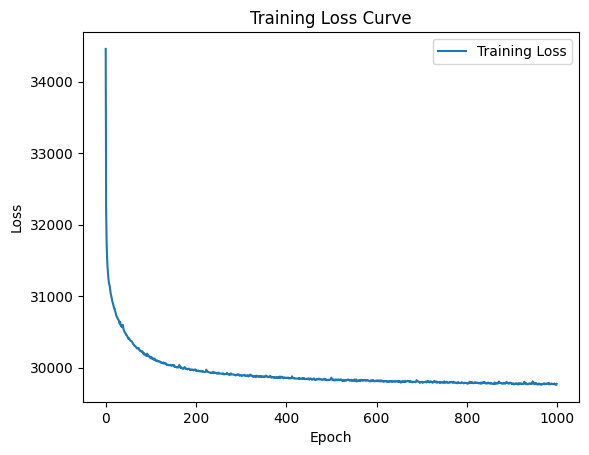

In [97]:
# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

train_losses=[]
vae.to(device)

start_time = time.time()

for epoch in range(epochs):
    vae.train()
    total_loss = 0
    for batch in data_loader:
        images = batch[0].to(device)  # Extract tensor from the batch list

        # Apply noise to input images
        noisy_images = apply_noise(images, std_dev=0.1)
        
        #Forward pass
        optimizer.zero_grad()
        recon_images, mean, logvar = vae(noisy_images)
        
        # Compute reconstruction loss
        recon_loss = criterion(recon_images, images)

        # Compute KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

        # Total loss
        loss = recon_loss + kl_weight * kl_loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print average loss for the epoch
    average_loss = total_loss / len(data_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {average_loss:.4f}")
    train_losses.append(average_loss)
# Save the trained model
#torch.save(vae.state_dict(), "vae_model.pth")
end_time = time.time()
processing_time = end_time - start_time
print(f"Processing time: {processing_time} seconds")
# Plot loss curve
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()


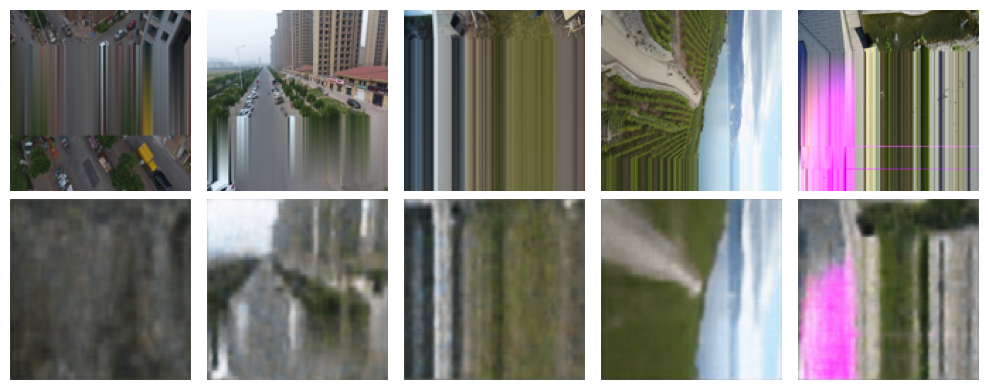

In [98]:
# Move the images tensor to the same device as the VAE model
device = next(vae.parameters()).device
images = images.to(device)

# Generate reconstructed images
vae.eval()
with torch.no_grad():
    reconstructed_images, _, _ = vae(images)

# Plot original and reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
for i in range(5):
    axes[0, i].imshow(images[i].permute(1, 2, 0).cpu())
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed_images[i].permute(1, 2, 0).cpu())
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

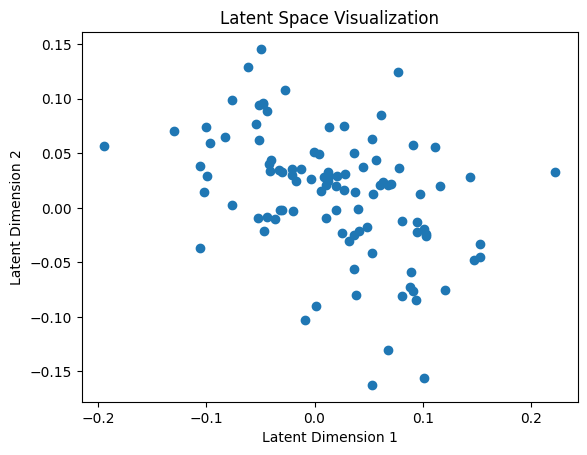

array([-0.02592441, -0.01251553, -0.04134958,  0.01564862, -0.03310923,
        0.03659913,  0.04342201, -0.09036788,  0.02376938,  0.05068929,
        0.07404065,  0.08470483,  0.05668666,  0.02940675,  0.0249032 ,
       -0.00955755,  0.06240564, -0.15570785,  0.03760285,  0.05774591,
        0.09872983,  0.03261795, -0.07229672,  0.05914661,  0.02133883,
       -0.00943523, -0.10308783, -0.0085281 , -0.0016435 , -0.05645632,
        0.07652451,  0.09385267, -0.03678013,  0.02481637,  0.03527102,
        0.07055376, -0.05883275,  0.03560148,  0.01301981, -0.07616842,
       -0.0012309 ,  0.06512497,  0.12897018,  0.02005611,  0.07530969,
        0.00277089,  0.02818598,  0.04426503, -0.08080605,  0.02836359,
        0.02668591,  0.1456801 , -0.02125229, -0.01271596, -0.07509837,
       -0.01939524,  0.01615413, -0.04738234,  0.01281379, -0.01765973,
        0.01421956,  0.01959074,  0.03988164, -0.00996709,  0.03397784,
       -0.00228547, -0.02130943, -0.02489034,  0.02885065,  0.05

In [99]:
vae.eval()
with torch.no_grad():
    _, latent_means, _ = vae(images)

# Move tensor to CPU and convert to NumPy array
latent_means_cpu = latent_means.cpu().numpy()

# Plot latent space
plt.scatter(latent_means_cpu[:, 0], latent_means_cpu[:, 1])
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization')
plt.show()

latent_means_cpu[:, 1]

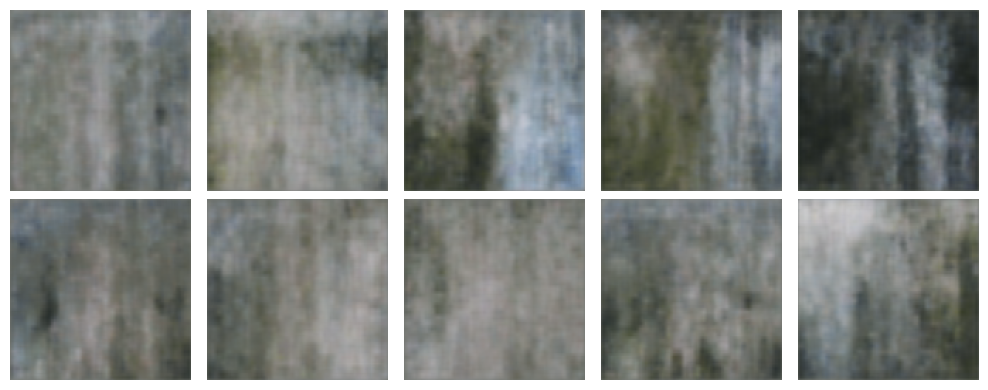

In [100]:
# Generate random samples from the latent space
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
for i in range(10):
    axes[i // 5, i % 5].imshow(generated_samples[i].cpu().permute(1, 2, 0).numpy())
    axes[i // 5, i % 5].axis('off')
plt.tight_layout()
plt.show()

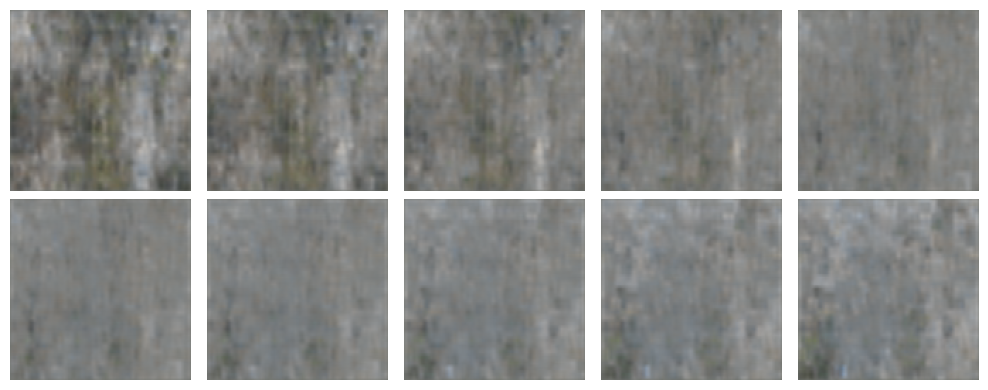

In [101]:
latent_point_1 = torch.randn(latent_dim).to(device)
latent_point_2 = torch.randn(latent_dim).to(device)

# Move latent_point_2 to the same device as latent_point_1
latent_point_2 = latent_point_2.to(latent_point_1.device)

# Interpolate between the two points
num_steps = 10
interpolation_weights = torch.linspace(0, 1, num_steps).unsqueeze(1).to(device)
interpolated_latents = torch.lerp(latent_point_1, latent_point_2, interpolation_weights)
with torch.no_grad():
    interpolated_samples = vae.decode(interpolated_latents)

# Plot interpolated samples
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
for i in range(num_steps):
    axes[i // 5, i % 5].imshow(interpolated_samples[i].permute(1, 2, 0).cpu())
    axes[i // 5, i % 5].axis('off')
plt.tight_layout()
plt.show()


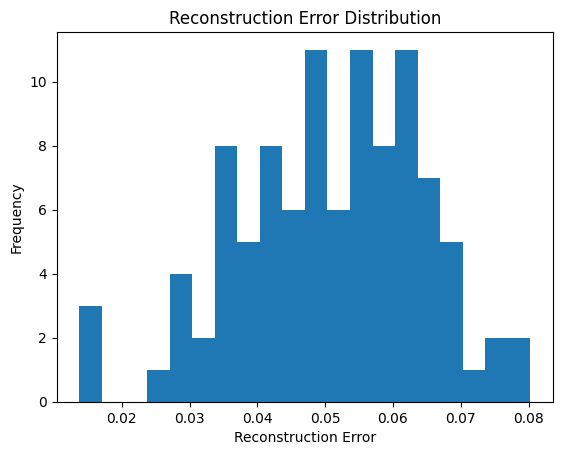

In [102]:
# Generate reconstructed images
vae.eval()
with torch.no_grad():
    reconstructed_images, _, _ = vae(images)

# Compute reconstruction errors
reconstruction_errors = torch.abs(reconstructed_images - images)
reconstruction_errors = reconstruction_errors.view(reconstruction_errors.size(0), -1)
reconstruction_errors = torch.mean(reconstruction_errors, dim=1)

# Plot reconstruction error distribution
plt.hist(reconstruction_errors.cpu().numpy(), bins=20)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution')
plt.show()

In [103]:
vae.eval()
with torch.no_grad():
    reconstructed_images, _, _ = vae(images)


from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity

# Assuming 'images' contains the original images and 'reconstructed_images' contains the reconstructed images
images_np = images.cpu().numpy()
reconstructed_images_np = reconstructed_images.cpu().numpy()

mse = mean_squared_error(images_np, reconstructed_images_np)
psnr = peak_signal_noise_ratio(images_np, reconstructed_images_np)
ssim = structural_similarity(images_np, reconstructed_images_np, win_size=3, channel_axis=0)

print(f"MSE: {mse:.4f}")
print(f"PSNR: {psnr:.4f}")
print(f"SSIM: {ssim:.4f}")



MSE: 0.0051
PSNR: 22.9070
SSIM: 0.7548
